# Inference and analysis of cell-cell communication using CellAgentChat

This tutorial provides a step-by-step guide on performing inference, analysis, and visualization of a cell-cell communication network for a single dataset using CellAgentChat. We demonstrate the diverse capabilities of CellAgentChat by applying it to scRNA-seq data obtained from cells of human squamous cell carcinoma patients.

CellAgentChat relies on user-provided gene expression data of cells and utilizes prior knowledge of signaling ligand-receptor interactions to model the probability of cell-cell communication. In this tutorial, we also showcase the incorporation of spatial transcriptomics data, which allows the model to consider the spatial proximity between cells when calculating cell-cell communication.

CellAgentchat also provides an animation framework to view the interaction receiving strength of individual cells in real time. Once the intercellular communication network is inferred, CellAgentChat offers additional functionality for exploring, analyzing, and visualizing the data.

### Load Packages

In [1]:
from preprocessor import *
from trajectory import *
import model_setup
from model_setup import *
import scanpy as sc
import permutations
from permutations import *
import Communication
from Communication import *
import abm
from abm import *
import bckground_distribution
from bckground_distribution import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Data input, processing and initialization

### Load Input Files

CellAgentChat requires two inputs: one is the gene expression data of cells, and the other is user assigned cell labels (i.e cell types/clusters). Optionally, the user can supply the spatial coordinates of cells, the pseudotime trajectory of cell (see pseudotime tutorial) and x_umap (optional, used for plotting). 

In [2]:
gene_expression = pd.read_csv('gene_expression.csv', index_col='cell')
meta = pd.read_csv('meta.csv', index_col='cell')

#optional
spatial = pd.read_csv('spatial_coordinates.csv', index_col='cell')
x_umap = pd.read_csv('x_umap.csv', index_col='cell') #for plotting

### Create anndata object

Create anndata object from input files. If no spatial information is available set ```coordinates = None```

In [3]:
adata = create_anndata(gene_expression=gene_expression, meta=meta, x_umap=x_umap, coordinates=spatial)


### Preprocess data

Normalized data (e.g., cells and gene filtered, library-size normalization and then log-transformed with a pseudocount of 1) is required as input for CellAgentChat analysis. If user provides count data, we provide an ```expression_processor``` function. In our example, the data is already normalized.

In [ ]:
adata = expression_processor(adata, normalize = True)

### Plot spatial coordinates

Plot the spatial coordinates of each cell. Requires the ```x_umap``` input. 

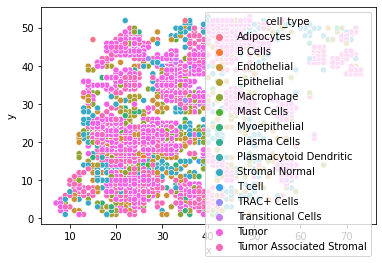

In [13]:
plot_spatial(adata)

## Part 2: Model Setup

### Loading Database

The default database is derived from CellTalkDB which is a manually curated database of literature-supported ligand-receptor interactions in humans and mouse. CellTalkDB contains almost 3400 validated molecular human interactions and over 2000 validated mouse interactions.

Change ```file = 'mouse_lr_pair.tsv'``` for mouse database.

Users can upload their own database file with curated ligand-receptor pairs.

In [3]:
lig_uni, rec_uni, lr_pairs = load_db(adata, file = 'human_lr_pair.tsv',sep='\t')
#'../Revision/new_ccdb.csv'

Loading Database...
Database Loaded!


CellAgentChat incorporates prior knowledge of TF-receptor and TF-gene ```human``` or ```mouse``` interactions from pre-existing databases to create a partially connected feedforward network.

In [4]:
tf_uni, rec_tf_uni = load_tf_db("human", adata, rec_uni)

### Deep Learning Model to estimate downstream expression

Setup and train neural network. The neural network takes as input a vector vr<sub>i</sub> representing expression of all receptors in cell i. This receptor expression vector is then fed into the neural network (F) to predict the expression x<sub>i</sub>  of all genes in cell i (regression task). The neural network structure was composed the following components: one input layer, one hidden layer, and output layer. The input layer is of size equivalent to the number of receptors. The output layer is the same size as the number of all genes. The hidden layer is of size one thousand representing transcription factors involved in downstream signaling pathways.

The neural network takes as input two vectors, x<sub>j</sub><sup>R</sup>, representing expression of all receptors in cell j and $\frac{1}{N}$ $\sum_{i=1}^N$ x<sub>i</sub><sup>L</sup>, representing the average expression of all ligands across the set of all N cells. These two vectors are then fed into the neural network (f) to predict the expression $\hat{x}_j^R$ of all genes in cell j (regression task). The neural network structure comprises the following components: two input layers, two hidden layers, and one output layer. The size of the two input layers corresponds to the number of ligands and receptors, respectively. The first hidden layer is dedicated to representing specific LR pairs. Each node in this layer receives two connections, one corresponding to a ligand and the other to a receptor, thus encapsulating the unique LR pair interactions. The second hidden layer represents transcription factors involved in downstream signaling pathways. We leverage scSeqComm, a database that incorporates insights from KEGG and REACTOME pathways to delineate the association between a receptor and its downstream transcription factors (TFs), to inform the connections between this layer and the previous one. The output layer is responsible for outputting downstream gene expression predictions. To establish connections between known TFs and their downstream gene targets, we utilize prior knowledge from databases such as TRRUST v2, HTRIdb, and RegNetwork. If specific information regarding the target genes of certain TFs is unavailable, we utilize dense connections.

The model is saved to the path provided in the ```path``` argument.

In [5]:
mat, C = train(adata, lig_uni, rec_uni, tf_uni, rec_tf_uni, lr_pairs, path="model.pt")

Setting up model
Training model...
epoch: 0
tensor(0.0884, grad_fn=<MseLossBackward0>)
epoch: 1
tensor(0.0878, grad_fn=<MseLossBackward0>)
epoch: 2
tensor(0.0871, grad_fn=<MseLossBackward0>)
epoch: 3
tensor(0.0865, grad_fn=<MseLossBackward0>)
epoch: 4
tensor(0.0858, grad_fn=<MseLossBackward0>)
epoch: 5
tensor(0.0851, grad_fn=<MseLossBackward0>)
epoch: 6
tensor(0.0843, grad_fn=<MseLossBackward0>)
epoch: 7
tensor(0.0835, grad_fn=<MseLossBackward0>)
epoch: 8
tensor(0.0825, grad_fn=<MseLossBackward0>)
epoch: 9
tensor(0.0816, grad_fn=<MseLossBackward0>)
epoch: 10
tensor(0.0805, grad_fn=<MseLossBackward0>)
epoch: 11
tensor(0.0793, grad_fn=<MseLossBackward0>)
epoch: 12
tensor(0.0780, grad_fn=<MseLossBackward0>)
epoch: 13
tensor(0.0766, grad_fn=<MseLossBackward0>)
epoch: 14
tensor(0.0749, grad_fn=<MseLossBackward0>)
epoch: 15
tensor(0.0730, grad_fn=<MseLossBackward0>)
epoch: 16
tensor(0.0708, grad_fn=<MseLossBackward0>)
epoch: 17
tensor(0.0682, grad_fn=<MseLossBackward0>)
epoch: 18
tensor(0.06

Load deep learning model

In [13]:
model_dl = load_model("model.pt")

### Caculate conversion rates for each receptor

With the trained neural network regressor, we then perform sensitivity analysis to score each input receptor based on how much impact it imposes on the downstream gene expression. This is known as the conversion rate for a receptor. 

In [ ]:
conversion_rates = feature_selection(model = model_dl, mat=mat, C=C, rec_uni=rec_uni)

Save conversion rates

In [10]:
save_conversion_rate(conversion_rates, file='conversion_rates.txt')

Done


Load conversion rates

In [5]:
conversion_rates = load_conversion_rate(file='conversion_rates.txt')
rates = add_rates(conversion_rates, rec_uni)

Conversion rates loaded


### Background Distribution

We employed a random permutation test to calculate the statistical significance p-value associated with each ligand-receptor interaction score. The significant interactions between two cell groups are identified using a permutation test by randomly permuting the group labels of cells and then recalculating the interaction score for each ligand receptor. After each permutation the ligand-receptor score is stored regardless of what cell type pair it came from. 

The ```threshold``` argument sets the minimum number of score values needed on average for each ligand-receptor pair. We recommend atleast a ```threshold=10000``` or greater.

```dist=True```  specifies that we want to consider the spatial coordinates of cells when infering cellular interaction. This leads to the calculation of the average distance between cells, which will be used in the subsequent steps. When spatial information is not provided ```dist=False``` should be set. 

```N``` specifies the number of cells to include in the calculation. By defualt all the cells are included, but the user can specify to use less. 

In [6]:
test_scores, model2, distance = permutation_test(threshold = 10000, N=len(adata.obs), adata=adata, 
                                                 lig_uni=lig_uni, rec_uni=rec_uni, rates=rates, dist=True)

iteration: 0
35.46909903201787
iteration: 1
71.34177215189874
iteration: 2
107.97840655249442
iteration: 3
142.90022338049144
iteration: 4
179.265078183172
iteration: 5
214.48026805658972
iteration: 6
249.35889798957558
iteration: 7
284.60982874162323
iteration: 8
319.9143708116158
iteration: 9
356.00819061801934
iteration: 10
392.49664929262843
iteration: 11
428.41102010424424
iteration: 12
464.7982129560685
iteration: 13
500.3060312732688
iteration: 14
535.5807892777364
iteration: 15
571.9590469099032
iteration: 16
607.283693224125
iteration: 17
642.7520476545048
iteration: 18
678.3626209977662
iteration: 19
714.6336559940432
iteration: 20
751.0588235294117
iteration: 21
787.3276247207743
iteration: 22
821.7915115413253
iteration: 23
857.897244973939
iteration: 24
893.5547282204021
iteration: 25
927.855547282204
iteration: 26
963.1697691734922
iteration: 27
999.8652271034996
iteration: 28
1034.1608339538348
iteration: 29
1069.4542069992553
iteration: 30
1105.572598659717
iteration: 3

9004.691734921817
iteration: 252
9038.804169769173
iteration: 253
9075.279970215934
iteration: 254
9111.288905435593
iteration: 255
9147.681310498883
iteration: 256
9182.998510796724
iteration: 257
9216.970960536113
iteration: 258
9253.014147431124
iteration: 259
9289.69024571854
iteration: 260
9326.447505584512
iteration: 261
9361.040208488459
iteration: 262
9396.876396128071
iteration: 263
9432.447505584512
iteration: 264
9467.256142963515
iteration: 265
9502.791511541325
iteration: 266
9539.6269545793
iteration: 267
9575.24571854058
iteration: 268
9611.475055845123
iteration: 269
9648.505584512286
iteration: 270
9684.861504095308
iteration: 271
9720.093819806403
iteration: 272
9756.539091586
iteration: 273
9792.959791511541
iteration: 274
9828.408041697692
iteration: 275
9864.187639612806
iteration: 276
9899.460908414
iteration: 277
9936.565152643336
iteration: 278
9972.032017870439
iteration: 279
10007.248696947134


The average distance between all cells

In [7]:
distance

17.09968921592907

For each ligand-receptor pair, we fit the random score distribution with a gamma distribution. By fitting the observed interaction scores (for a specific Ligand-Receptor) pair to a Gamma distribution, we get the estimated parameters (alpha and scale) of the gamma distribution to represent the random interaction score distribution of the Ligand-Receptor pair. 

Due to the computational expense of calculating the distances between all cells in the dataset, the permutation test can be quite costly, especially when considering spatial information. To address this, we have devised a method to match the background gamma distribution of non-spatial calculations with that of spatial ones by scaling the parameters. If the parameters must be scaled the ```dist``` parameter must be given the average distance between the  cells and the ```scale``` parameter must be set to ```True```. 

In [9]:
params = get_distribution(test_scores, dist=distance, scaled=True)

Getting background distribution for each ligand-receptor pair


Save the background distribution for each ligand to the given path

In [10]:
save_distribution(params, path='new_distribution.csv')

Distribution Saved


Load the background distribution for each ligand to the given path

In [6]:
params = load_distribution(file='new_distribution.csv')

Distribution loaded


### Get choices

When inferring cell communication, the following three lists are used to track specific receptors, ligand-receptor pairs, or cell types:

```proteins``` contains all the receptors in database. 

```pairs``` contains all the ligand-receptor pairs in the database. 

```clusters``` contains all the cell types/clusters present in the dataset. 

In [ ]:
proteins = get_protein_choices(rec_uni)
pairs = get_lr_choices(rec_uni, lig_uni)
clusters = get_cluster_choices(adata)

## Part 3: Inference of cell-cell communication network

We provide a function ```CCI``` calculate cell-cell interactions. 

Optional Parameters:

```delta```: Influences the degree of cell-to-cell distance. For long-range mode, a delta value less than 1 is used. This promotes interactions over long distance ranges. While for short-range mode, a delta value greater than 1 is employed, promoting interactions over closer distance ranges [1].

```max_steps```: Number of iterations to be performed in the simulation [1]. 

```tau```: The degree of the freedom for the distance [2].

```rec_block```: Receptor to be obstructed by in-silico receptor blocking. Interactions involving the chosen receptor will not occur [False].

```plot_every_step```: Whether to plot results after every step [True].

```path```: output path/directory [/out].

```interaction_matrix```: Name of the interaction_matrix results file [interaction_matrix.csv].

```sig_lr_pair```: Name of the file consisting of all the inferred cell-cell communications at the level of ligands/receptors [sig_lr_pair.csv].

```pvalues_name```: Name of the file consisting of the pvalues for the interactions that correspond to the ```sig_lr_pair``` file [pvalues.csv]. 

```pvalues2_names```: Name of the file consisting of the pvalue group (0.05 < p < 0.025, 0.025< p < 0.01, p < 0.01) for the interactions that correspond to the ```sig_lr_pair``` file [pvalues2.csv]. 

```cluster_name```: Name of the file that stores the list of cell types(for plotting) [cluster_names.csv].

```threshold```: The pvalue threshold for significant interactions [0.05]

```net```: Neural network model path

In [13]:
abm_model = CCI(N=len(adata.obs), adata=adata, lig_uni=lig_uni, rec_uni=rec_uni, max_steps=1,
    rates=rates, distribution=params, clusters=clusters, dist=True, threshold=0.05, net="model.pt")

Calculating Interactions
Step: 0
Average Distance: 11.950727321932126
Calculating Significant Interactions
2207 significant interactions
Percentage of significant interactions: 5.011694711265527
Saving Files
Saved files
Plotting results
null device 
          1 


Warning message:
Using size for a discrete variable is not advised. 


Step: 1
Calculating Significant Interactions
2213 significant interactions
Percentage of significant interactions: 5.025319617594295
Saving Files
Saved files
Plotting results
null device 
          1 


Warning message:
Using size for a discrete variable is not advised. 


The CCI function calculates all significant ligand-receptor interactions and plots a heatmap and dotplot of the results. 

Optionally if all the results are obtained, plotting the results can be done separately.

In [ ]:
plotting()

## Part 4: Receptor Blocking Petrubation Analysis Tutorial

This section provides a brief guide on performing CellAgentChat's receptor blocking analysis. CellAgentChat's deep learning model is used to estimate the impact of blocking a receptor on the downstream gene expression. This identifies the top most perturbed genes (target genes) from receptor blocking. This is visualized by a bar plot which shows the degree of perturbation of the target genes and a matrix plot which shows the expression of each target gene across the cell type populations. If many perturbed genes are linked with the disease of interest, this may indicate the receptor blocked is a potential therapeutic target.

Here we run the CCI function adding in the rec_block parameter to block the receptor CD44. Inference of CCI will occur with the exclusion of interactions involving the receptor CD44 and LRP1. Following CCI inference, CellAgentChat's receptor blocking analysis will determine the top 50 most perturbed downstream genes.

Calculating Interactions
Step: 0
Average Distance: 11.950727321932126
Blocked Receptor Analysis
Get original
Getting Target Genes for receptor: CD44
Getting Target Genes for receptor: LRP1
Plotting results for receptor: CD44


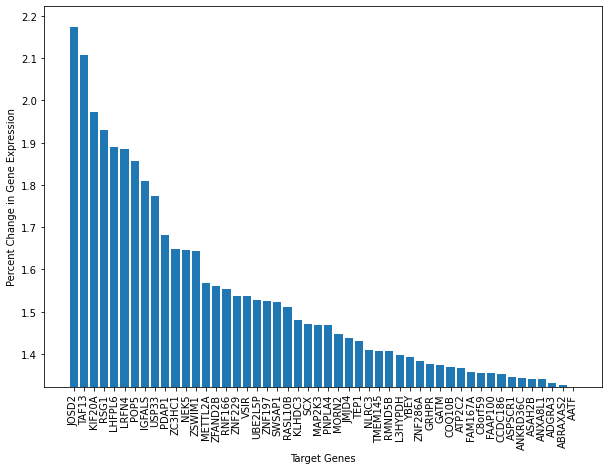

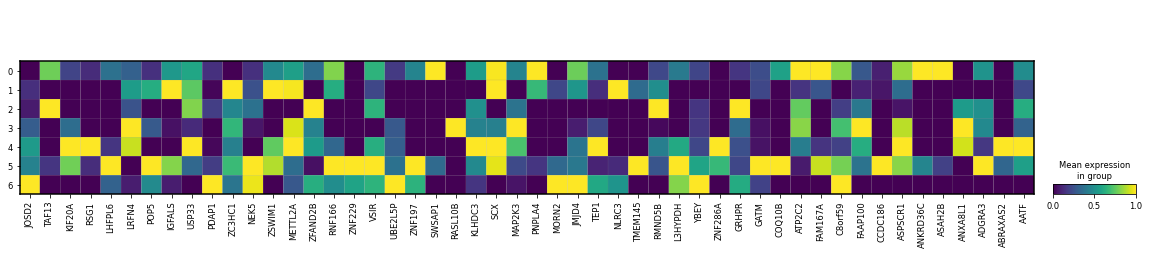

Plotting results for receptor: LRP1


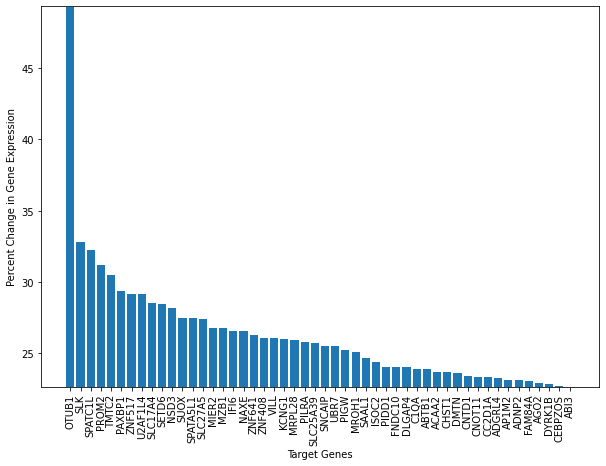

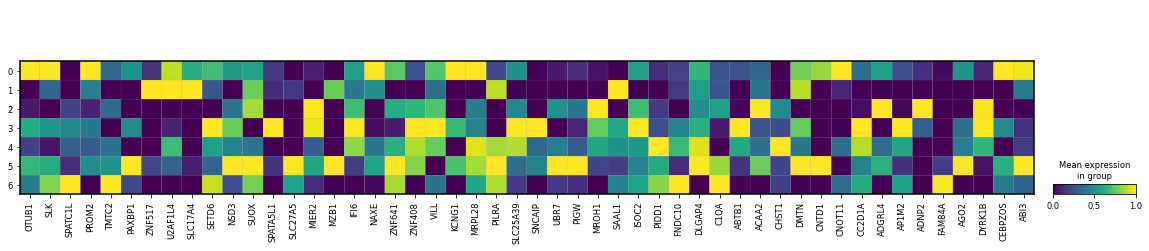

plots saved to directory /figures
Calculating Significant Interactions
2207 significant interactions
Percentage of significant interactions: 5.011694711265527
Saving Files
Saved files
Plotting results


Error: You should have at least two distinct break values.
Execution halted
Warning message:
Using size for a discrete variable is not advised. 


In [12]:
CCI(N=len(adata.obs), adata=adata, lig_uni=lig_uni, rec_uni=rec_uni, max_steps=1,
    rates=rates, distribution=params, clusters=clusters, dist=True, threshold=0.05, net="../pdac_train", 
    rec_block=['CD44','LRP1'])

Here the receptor blocking analysis outputs the most perturbed downstreams genes (target genes) when CD44 and LRP1 are blocked. This is displayed using a bar graph to illustrate the degree to which the target genes are affected and a matrix plot to visualize the expression of the target genes across the various cell type populations.

### Receptor Blocking Analysis without CCI Inferece

Optionally, the receptor blocking analysis can be done without calculating CCI inference by calling the ```block_receptor``` function. 

Parameters:

```adata```: Anndata object containing the required agent states for CellAgentChat.

```receptors```: A list containing the receptors to be blocked.

```rec_uni```: The receptor universe.

```lig_uni```: The ligand universe.

```net```: The neural network model path

```threshold```: The number of 'target genes' to obtain [50].

In [ ]:
rec_to_block = ['CD44', 'LRP1']
block_receptors(adata=adata, receptors = rec_to_block, rec_uni=rec_uni, lig_uni=lig_uni, net="model.pt",
                threshold=50)

All result files and plots saved in the ```figures``` directory.

Using the list of target genes, we can check to see if any of them are associated with the disease of interest using external tools. If many target genes are linked with the disease of interest, this may indicate the receptor blocked is a potential therapeutic target.

## Part 5: Inference and analysis of individual cell interactions using CellAgentChat

This section provides a brief guide on CellAgentChat's capabilities in measuring cell interactions of individual cells. With the power of agent-based models, CellAgentChat is able to infer interactions at the cell level, in contrast to other methods which are only able to infer interactions at the cell population level.

Using the receiving score function, we can obtain the cell receiving score of each individual cell. The receiving score is the total number of interactions received to a cell.

The model parameter is the CellAgentChat model used for CCI Inference above.

In [14]:
data = receiving_score(model=abm_model, path='out')
data

results saved to: out/cell_receiving_scores.csv


,Cell,Cell Type,Receiving Score
0,10x10,6,10.976155
1,10x13,0,6.988728
2,10x14,0,5.110713
3,10x15,0,2.242771
4,10x16,0,3.681851
...,...,...,...
402,9x26,0,4.942971
403,9x27,0,2.317384
404,9x29,0,3.438375
405,9x30,0,3.520226


A csv file containing the receiving scores of each cell is also saved to the path directory.

Below the receiving scores are sorted in descending order.

In [15]:
data.sort_values(by=['Receiving Score'], ascending=False)

,Cell,Cell Type,Receiving Score
105,15x16,5,28.506292
124,16x14,5,27.452106
372,6x10,6,23.656941
371,5x9,6,23.160137
125,16x15,5,23.145915
...,...,...,...
262,23x18,1,0.325393
282,24x23,3,0.233372
247,22x18,1,0.191339
214,20x22,1,0.154242


## Part 6: Animation platform

Model parameters described in part 3 and in our animation tutorial video.

In [9]:
model_params = abm_copy.parameters(adata, lig_uni, rec_uni, rates, clusters, pairs, proteins)

Call the animation platform. This will produce a popup to the animation server. If not considering spatial information ```dist_on``` must be set to ```False```. Otherwise ```dist_on=True```. 

Note: The animation platform needs to be re opened with a different ```port``` number at every use (as long as the same jupyter notebook file is open).  

In [ ]:
abm.visualization(adata, model_params, dist_on=True, port=8521)